## hetGPy SIR Example

This document walks through the SIR example from the `hetGP` package



In [1]:
import sys
sys.path.append('../')
from hetgpy.hetGP import hetGP
from rpy2.robjects import r
from scipy.io import loadmat
from scipy.stats import norm
import numpy as np

# data
m = loadmat('../tests/data/SIR.mat')
X = m['X']
Z = m['Y']
xseq = np.linspace(0,1,100)
xgrid = np.array([(y,x) for x in xseq for y in xseq])

model = hetGP()

model.mleHetGP(
    X = X,
    Z = Z,
    covtype = "Matern5_2",
    lower = np.array([0.5,0.5]),
    upper = np.array([2,2]),
    maxit = 1e3
)
preds = model.predict(xgrid)
preds['upper'] = norm.ppf(0.95, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()
preds['lower'] = norm.ppf(0.05, loc = preds['mean'], scale = np.sqrt(preds['sd2'] + preds['nugs'])).squeeze()

In [4]:
r('''library(R.matlab)
        library(hetGP)
        m = readMat("../tests/data/SIR.mat")
        X = m[["X"]]
        Z = m[["Y"]]
        xseq  = seq(0,1,length.out = 100)
        xgrid = as.matrix(expand.grid(xseq,xseq))
        model = mleHetGP(
                X = X,
                Z = Z,
                covtype = "Matern5_2",
                lower = c(0.05,0.05),
                upper = c(2,2),
                maxit = 1e4
            )
        preds = predict(model,xgrid)
        # predictive interval
        preds$upper = qnorm(0.95, preds$mean, sqrt(preds$sd2 + preds$nugs))
        preds$lower = qnorm(0.05, preds$mean, sqrt(preds$sd2 + preds$nugs))
''')
r_preds = dict(mean = np.array(r('preds$mean')),
               upper = np.array(r('preds$upper')),
               lower = np.array(r('preds$lower'))
)

And then we can plot:

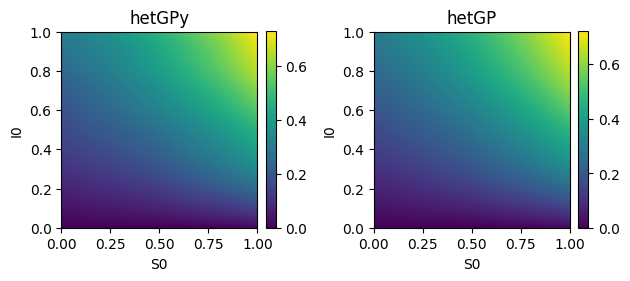

In [18]:
import matplotlib.pyplot as plt
f, ax = plt.subplots(nrows=1,ncols=2)

# data
ax0 = ax[0].imshow(preds['mean'].reshape(100,100),origin='lower',extent=[0,1,0,1])
ax1 = ax[1].imshow(r_preds['mean'].reshape(100,100),origin='lower',extent=[0,1,0,1])
ax[0].set_title('hetGPy')
ax[1].set_title('hetGP')
for a in ax:
    a.set_xlabel('S0')
    a.set_ylabel('I0')
f.colorbar(ax0, ax = ax[0],fraction=0.046,pad=0.04)
f.colorbar(ax1, ax = ax[1],fraction=0.046,pad=0.04)
f.tight_layout()